# Maximum global frequency by mutational effect

In this analysis, we will determine the relationship between a mutation's effect and its maximum frequency achieved in the circulating human H3N2 influenza virus population. 

We will use the experimentally-determined site-specific amino-acid preferences for the Perth/2009 H3 HA to calculate mutational effect. The effect of mutating site $r$ from amino acid $a_1$ to $a_2$ is defined as:
$$ \log_2 \frac{\pi_{r,a_2}}{\pi_{r,a_1}}$$
where $\pi_{r,a1}$ and $\pi_{r,a2}$ are the re-scaled preferences for amino acids $a_1$ or $a_2$ at site $r$.
These preferences were determined in the notebook [./analysis_notebook.ipynb/](./analysis_notebook.ipynb/).

The human H3N2 phylogenetic trees and frequencies were determined using the [Nextstrain](https://nextstrain.org/) pipeline `augur`.

## Import modules, define directories

In [106]:
%matplotlib inline
import os
import re
import Bio
import Bio.Phylo
import pickle
import gzip
import io
import json
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
import seaborn as sns
import random
import pandas as pd
import scipy
from scipy.stats import spearmanr

# Use simple plot style with figures sized for context of a talk.
sns.set_style("ticks")
#sns.set_context("talk")

# Turn off spines for all plots.
plt.rc("axes.spines", top=False, right=False)

resultsdir = './results/'
inputdir = './data'
prefsdir = os.path.join(resultsdir, 'preferences/')
plotsdir = os.path.join(resultsdir, 'plots/')

## Configurations

In [107]:
frequency_bins = [0, 0.02, 0.10, 0.5, 0.99, 1]

cmap = plt.get_cmap("tab10")
global_colors = [cmap(0), cmap(1), cmap(2), cmap(3)]

color_per_label = {
    "pre-Perth": global_colors[0],
    "post-Perth": global_colors[1],
    "perth": (0.8, 0.8, 0.8, 1)
}

precision = 4
permutations = 10 ** precision

params = {
    'axes.labelsize': 12,
    'font.size': 12,
    'legend.fontsize': 10,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'text.usetex': False,
    'figure.figsize': [3.5, 3.5],
    'savefig.dpi': 120,
    'figure.dpi': 120
}
mpl.rcParams.update(params)

## Define functions

In [108]:
def json_to_tree(json_dict):
    """Returns a Bio.Phylo tree corresponding to the given JSON dictionary exported
    by `tree_to_json`.
    >>> import json
    >>> json_fh = open("tests/data/flu_h3n2_ha_3y_tree.json", "r")
    >>> json_dict = json.load(json_fh)
    >>> tree = json_to_tree(json_dict)
    >>> tree.name
    u'NODE_0002020'
    >>> len(tree.clades)
    2
    >>> tree.clades[0].name
    u'NODE_0001489'
    >>> hasattr(tree, "attr")
    True
    >>> "dTiter" in tree.attr
    True
    """
    node = Bio.Phylo.Newick.Clade()
    node.name = json_dict["strain"]

    if "children" in json_dict:
        # Recursively add children to the current node.
        node.clades = [json_to_tree(child) for child in json_dict["children"]]
    else:
        node.clades = []

    # Assign all non-children attributes.
    for attr, value in json_dict.items():
        if attr != "children":
            setattr(node, attr, value)

    if "aa_sequence" in json_dict["attr"]:
        node.aa_sequence = json_dict["attr"]["aa_sequence"]
    
    return node

# Biopython's trees don't store links to node parents, so we need to build
# a map of each node to its parent.
# Code from the Bio.Phylo cookbook: http://biopython.org/wiki/Phylo_cookbook
def all_parents(tree):
    parents = {}
    for clade in tree.find_clades(order='level'):
        for child in clade:
            parents[child] = clade
    return parents

def has_stop_codon(node):
    return "X" in node.aa_sequence or ("*" in node.aa_sequence and not node.aa_sequence.endswith("*"))

def calc_mutational_effect_for_tree(tree, stacked_preferences, gene_start_coordinates, perth_strain,
                                    positions=None, attr="mut_effect"):
    """
    """
    # Use all positions in the given sequence by default.
    default_preference = 1e-4
    aa_length = 566
    if positions is None:
        positions = list(range(aa_length))

    for node in tree.find_clades():
        mut_effect = 0
        total_mutations = 0

        if hasattr(node, "aa_muts"):
            for gene, muts in node.aa_muts.items():
                for mut in muts:
                    # Identify the original and mutation amino acids.
                    a1 = mut[0]
                    a2 = mut[-1]
                    
                    # Calculate absolute position of mutation in HA coordinates.
                    # Mutation coordinates from `aa_muts` are 1-based, while DMS
                    # preferences are zero-based.
                    r = int(mut[1:-1]) - 1 + gene_start_coordinates[gene]

                    # Calculate mutational effect if the mutation does not involve
                    # an unknown amino acid or stop codon.
                    if not r in positions and len(positions) == aa_length:
                        print("WARNING: Couldn't find position %i in all sites" % r)
                        
                    if "X" not in mut and "*" not in mut and r in positions:
                        mut_effect += np.log2(
                            stacked_preferences.get((r, a2), default_preference) / 
                            stacked_preferences.get((r, a1), default_preference)
                        )
                        total_mutations += 1
                        
        setattr(node, attr, mut_effect)
        node.attr[attr] = mut_effect
        node.attr["%s_mutations" % attr] = total_mutations

def node_has_head_mutations(node):
    """
    Returns True if the given node has any mutations in the head domain.
    """
    gene = "HA1"
    head_range = [52, 277]
    gene_start_coordinates = {
        "SigPep": 0,
        "HA1": 16,
        "HA2": 345
    }
    
    if hasattr(node, "aa_muts"):
        for mut in node.aa_muts[gene]:
            genomic_mut = int(mut[1:-1]) - 1 + gene_start_coordinates[gene]
            if head_range[0] <= genomic_mut <= head_range[1]:
                return True
        
    return False
        
# Collect date and trunk status for each
# node prior to the MRCA of all recent nodes.
def build_frame_for_nodes(nodes):
    nodes_df = []
    for node in nodes:
        node_values = {
            "mut_effect": node.attr["mut_effect"],
            "wsn_mut_effect": node.attr["wsn_mut_effect"],
            "date": node.attr["num_date"],
            "trunk": node.is_trunk,
            "terminal": node.is_terminal(),
            "name": node.name,
            "clade_id": node.clade,
            "max_frequency": node.attr["max_frequency"],
            "tips": node.tips,
            "total_mutations": node.attr["mut_effect_mutations"],
            "perth_status": node.attr["perth_status"],
            "has_head_mutations": node_has_head_mutations(node)
        }

        nodes_df.append(node_values)
            
    nodes_df = pd.DataFrame(nodes_df)

    return nodes_df

def spearman_permutation_test(x, y, permutations=100):
    """Returns a Spearman's rho for the given arrays, x and y, and
    a p-value corresponding to the proportion of permutations for
    which the rho between permuted data is greater than or equal to
    the observed rho.
    """
    rho, pvalue = spearmanr(x, y)
    successes = 0
    
    for i in range(permutations):
        y_permuted = np.random.permutation(y)
        permuted_rho, permuted_pvalue = spearmanr(x, y_permuted)
        
        if abs(permuted_rho) >= abs(rho) and (permuted_rho * rho) >= 0:
            successes += 1
    
    return rho, (successes / float(permutations))

In [109]:
def plot_tree(tree_to_plot, dms_strain, color_per_label, excluded_clades):
    # Plot H3N2 tree in BALTIC style from Bio.Phylo tree.

    #mpl.rcParams['font.weight']=300
    #mpl.rcParams['axes.labelweight']=300
    #mpl.rcParams['font.size']=22

    yvalues = [node.yvalue for node in tree_to_plot.find_clades()]
    y_span = max(yvalues)
    y_unit = y_span / float(len(yvalues))

    #
    # Setup the figure grid.
    #

    fig, ax = plt.subplots(1, 1, figsize=(8, 4), facecolor='w')

    L=len([k for k in tree_to_plot.find_clades() if k.is_terminal()])

    # Setup arrays for tip and internal node coordinates.
    tip_circles_x = []
    tip_circles_y = []
    tip_circles_color = []
    tip_circle_sizes = []
    node_circles_x = []
    node_circles_y = []
    node_circles_color = []
    node_line_widths = []
    node_line_segments = []
    node_line_colors = []
    branch_line_segments = []
    branch_line_widths = []
    branch_line_colors = []
    branch_line_labels = []

    for k in tree_to_plot.find_clades(): ## iterate over objects in tree
        x=k.attr["num_date"] ## or from x position determined earlier
        y=k.yvalue ## get y position from .drawTree that was run earlier, but could be anything else

        if k.parent is None:
            xp = None
        else:
            xp=k.parent.attr["num_date"] ## get x position of current object's parent

        if x==None: ## matplotlib won't plot Nones, like root
            x=0.0
        if xp==None:
            xp=x
                    
        if k.attr["perth_status"] == "perth_clade" or k.attr["num_date"] >= 2014.0:
            c = color_per_label["perth"]
        elif k.attr["perth_status"] == "post-Perth":
            c = color_per_label["post-Perth"]
        else:
            c = color_per_label["pre-Perth"]

        branchWidth=1
        if k.is_terminal(): ## if leaf...
            s=5 ## tip size can be fixed

            tip_circle_sizes.append(s)
            tip_circles_x.append(x)
            tip_circles_y.append(y)
            tip_circles_color.append(c)
        else: ## if node...
            k_leaves = [child
                        for child in k.find_clades()
                        if child.is_terminal()]

            # Instead of scaling branch widths by the number of tips
            # in each clade, scale by the predicted frequency.
            #branchWidth += 15.0 * predicted_freq_by_clade.get(k.clade, 0.0)

            if len(k.clades)==1:
                node_circles_x.append(x)
                node_circles_y.append(y)
                node_circles_color.append(c)

            ax.plot([x,x],[k.clades[-1].yvalue, k.clades[0].yvalue], lw=branchWidth, color=c, ls='-', zorder=9, solid_capstyle='round')

        branch_line_segments.append([(xp, y), (x, y)])
        branch_line_widths.append(branchWidth)
        branch_line_colors.append(c)

    branch_lc = LineCollection(branch_line_segments, zorder=9)
    branch_lc.set_color(branch_line_colors)
    branch_lc.set_linewidth(branch_line_widths)
    branch_lc.set_label(branch_line_labels)
    branch_lc.set_linestyle("-")
    ax.add_collection(branch_lc)

    # Add circles for tips and internal nodes.
    tip_circle_sizes = np.array(tip_circle_sizes)
    ax.scatter(tip_circles_x, tip_circles_y, s=tip_circle_sizes, facecolor=tip_circles_color, edgecolor='none',zorder=11) ## plot circle for every tip
    ax.scatter(tip_circles_x, tip_circles_y, s=tip_circle_sizes*2, facecolor='k', edgecolor='none', zorder=10) ## plot black circle underneath
    ax.scatter(node_circles_x, node_circles_y, facecolor=node_circles_color, s=50, edgecolor='none', zorder=10, lw=2, marker='|') ## mark every node in the tree to highlight that it's a multitype tree

    # Call out the DMS strain with a bordered star.
    star_size = 100
    ax.scatter([dms_strain.attr["num_date"]], [dms_strain.yvalue], marker="*", s=star_size, facecolor=["#fde725"], zorder=20)
    ax.scatter([dms_strain.attr["num_date"]], [dms_strain.yvalue], marker="*", s=star_size * 2, facecolor=["#000000"], zorder=19)

    # Annotate the DMS strain name.
    ax.text(dms_strain.attr["num_date"] + 1.75, dms_strain.yvalue - 8, dms_strain.strain)

    ax.set_ylim(-10, y_span + 10)

    ax.spines['top'].set_visible(False) ## no axes
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

    ax.grid(axis='x',ls='-',color='grey')
    ax.tick_params(axis='y',size=0)
    ax.set_yticklabels([])

    # Add legend for colors.
    patches = []
    patch_labels = set()
    for key in ["pre-Perth", "post-Perth", "perth"]:
        if key in excluded_clades:
            label = "excluded from analysis"
        else:
            label = key

        if not label in patch_labels:
            patches.append(mpatches.Patch(color=color_per_label[key], label=label))
            patch_labels.add(label)

    ax.legend(handles=patches)

    plt.tight_layout()

In [110]:
def find_dms_strain(tree):
    # Find the DMS strain.
    dms_strain = [node for node in tree.find_clades() if node.strain == "A/Perth/16/2009"][0]
    return dms_strain

In [111]:
# Function to load a tree, frequencies, and DMS preferences and return
# an annotated tree based on these data.
def load_and_annotate_tree_with_frequencies(tree_path, frequencies_path):
    # Load frequencies JSON file used by auspice. These data are compressed.
    # Decompress JSON data and load into a Python dict.
    with gzip.GzipFile(frequencies_path, "r") as json_uncompressed_fh:
        frequencies = json.loads(json_uncompressed_fh.read().decode('utf-8'))
        
    pivots = np.array(frequencies["pivots"])
    global_frequencies = {
        int(key.split(":")[-1]): np.array(values) for key, values in frequencies.items()
        if key.startswith("global_clade:")
    }
    
    # Load tree JSON file used by auspice. These data are compressed.
    # Decompress JSON data and load into a Python dict.
    with gzip.GzipFile(tree_path, "r") as json_uncompressed_fh:
        json_tree = json.loads(json_uncompressed_fh.read().decode('utf-8'))
        
    # Convert JSON tree layout to a Biopython Clade instance.
    tree = json_to_tree(json_tree)
    
    # Find the maximum frequency for each node in the tree.
    max_frequency_by_node = {}
    for node in tree.find_clades():
        max_frequency_by_node[node.clade] = global_frequencies[node.clade].max()
        
    # Find the DMS strain.
    dms_strain = find_dms_strain(tree)
    
    # Next, annotate each node with its parent.
    parents_by_node = all_parents(tree)
    for node in tree.find_clades():
        if node == tree.root:
            node.parent = None
        else:
            node.parent = parents_by_node[node]
            
    # Find all tips of the tree sampled since 2017.
    recent_nodes = [node for node in tree.get_terminals() if node.attr["num_date"] > 2017.83]
    
    # Find the last common ancestor of all recent nodes.
    mrca = tree.common_ancestor(recent_nodes)
    
    # Define nodes that are unresolved in the most recent lineages.
    unresolved_nodes = list(mrca.find_clades())
    
    # Assign the tree's trunk.
    for node in tree.find_clades():
        node.is_trunk = False
        
    # Find all nodes that are ancestral to recent nodes.
    # Label these ancestral nodes as part of the "trunk"
    # and collect the set of distinct nodes in the trunk.
    for recent_node in recent_nodes:
        current_node = recent_node.parent

        # Traverse from the current node to the tree's root.
        while current_node != tree.root:
            # Mark a node as part of the trunk if it was sampled
            # before the MRCA of all recent nodes.
            if current_node.attr["num_date"] < mrca.attr["num_date"]:
                current_node.is_trunk = True

            current_node = current_node.parent
    
    # Find the MRCA of any recent node and the Perth strain.
    perth_mrca = tree.common_ancestor([recent_nodes[0], dms_strain])

    # Prune all nodes in the corresponding child clades of that MRCA containing Perth.
    perth_mrca_trunk = [clade for clade in perth_mrca.clades if clade.is_trunk][0]

    # Find Perth strain's non-trunk ancestor.
    perth_ancestor = [clade for clade in perth_mrca.clades if not clade.is_trunk][0]
    
    # Find ids for all Perth ancestors and post-Perth nodes.
    perth_ancestor_ids = [node.clade for node in perth_ancestor.find_clades()]
    post_perth_ids = [node.clade for node in perth_mrca_trunk.find_clades()]

    # Annotate Perth status.
    for node in tree.find_clades():
        clade_id = node.clade
        
        if clade_id in perth_ancestor_ids:
            status = "perth_clade"
        elif clade_id in post_perth_ids:
            status = "post-Perth"
        else:
            status = "pre-Perth"
        
        node.attr["perth_status"] = status
    
    # Count tips below each clade.
    for node in tree.find_clades(order="postorder"):
        tips = 0
        for clade in node.clades:
            if clade.is_terminal():
                tips += 1
            else:
                tips += clade.tips

        node.tips = tips
    
    #
    # Calculate Perth-based mutational effects for nodes.
    #
    
    # Define start positions in amino acids for HA genes including SigPep, HA1, and HA2.
    # These positions will be used to calculate the absolute position in HA for amino acid
    # mutations annotated in gene-specific coordinates.
    gene_start_coordinates = {
        "SigPep": 0,
        "HA1": 16,
        "HA2": 345
    }
    
    # Load DMS preferences.
    preferences_file = "./results/H3renumberedprefs/summary_avgprefs_rescaled.csv"
    preferences = pd.read_csv(preferences_file)
    preferences.index.name = "HA_position"
    preferences = preferences.reset_index()
    
    # Stack preferences for all amino acids to enable indexing preferences
    # by site and amino acid with tuples.
    stacked_preferences = preferences.loc[:, "A":"Y"].stack()
    calc_mutational_effect_for_tree(tree, stacked_preferences, gene_start_coordinates, dms_strain)
    
    # Assign maximum frequency to each node.
    for node in tree.find_clades():
        node.attr["max_frequency"] = max_frequency_by_node[node.clade]
        
    #
    # Calculate WSN-based mutational effects for node.
    #
    
    wsn_gene_start_coordinates = {
        "SigPep": 0, 
        "HA1": 8, 
        "HA2": 342
    }
    
    # Load DMS preferences.
    # WSN preferences have already been converted to H3 numbering.
    wsn_preferences_file = "./data/WSN_avgprefs_rescaled_H3numbering.csv"
    wsn_preferences = pd.read_csv(wsn_preferences_file)
    wsn_preferences.index.name = "HA_position"
    wsn_preferences = wsn_preferences.reset_index()
    
    # Stack preferences for all amino acids to enable indexing preferences
    # by site and amino acid with tuples.
    wsn_stacked_preferences = wsn_preferences.loc[:, "A":"Y"].stack()
    calc_mutational_effect_for_tree(tree, wsn_stacked_preferences, wsn_gene_start_coordinates, dms_strain,
                                    attr="wsn_mut_effect")
    
    return tree

def get_mutations_data_frame_for_tree(tree):
    #
    # Build the data frame for nodes in the tree.
    #
    df = build_frame_for_nodes(list(tree.find_clades()))
    
    # Bin events by maximum frequency.
    df["max_frequency_bins"] = pd.cut(df["max_frequency"], bins=frequency_bins)
        
    # Omit nodes sampled from 2014 onward.
    df = df[df["date"] < 2014.0].copy()
    
    # Omit nodes occuring inside the Perth clade.
    df = df[df["perth_status"] != "perth_clade"].copy()
    
    # Keep only nodes with non-zero mutational effects.
    df = df[df["mut_effect"] != 0].copy()
    
    return df

## Load entire tree and frequency data

We are going to filter out nodes that occur on the clade with the Perth/2009 strain to eliminate nodes closely related to the Perth/2009 strain. We are also going to filter out nodes that occur after 2014, since at the time of this analysis, not enough time has elapsed for their evolutionary fates to be resolved.

In [112]:
tree = load_and_annotate_tree_with_frequencies(
    "./data/flu_h3n2_ha_1968_2018_6v_tree.json.gz",
    "./data/flu_h3n2_ha_1968_2018_6v_frequencies.json.gz"
)

In [113]:
df = get_mutations_data_frame_for_tree(tree)

In [114]:
dms_strain = find_dms_strain(tree)

In [115]:
df.shape

(1321, 13)

In [116]:
df.head()

,clade_id,date,has_head_mutations,max_frequency,mut_effect,name,perth_status,terminal,tips,total_mutations,trunk,wsn_mut_effect,max_frequency_bins
6,6,1968.413639,False,0.454441,-0.756004,NODE_0002175,pre-Perth,False,13,1,False,-5.804394,"(0.1, 0.5]"
7,7,1969.364369,True,0.034957,-3.623705,A/Bilthoven/808/1969,pre-Perth,True,0,5,False,9.231507,"(0.02, 0.1]"
9,9,1968.846194,True,0.034957,-10.962743,A/Aichi/2/1968,pre-Perth,True,0,2,False,1.801825,"(0.02, 0.1]"
10,10,1969.747027,True,0.034957,-0.697220,A/HongKong/3/1969,pre-Perth,True,0,3,False,5.884295,"(0.02, 0.1]"
11,11,1968.688786,True,0.314613,4.315892,NODE_0002179,pre-Perth,False,9,2,False,1.252967,"(0.1, 0.5]"


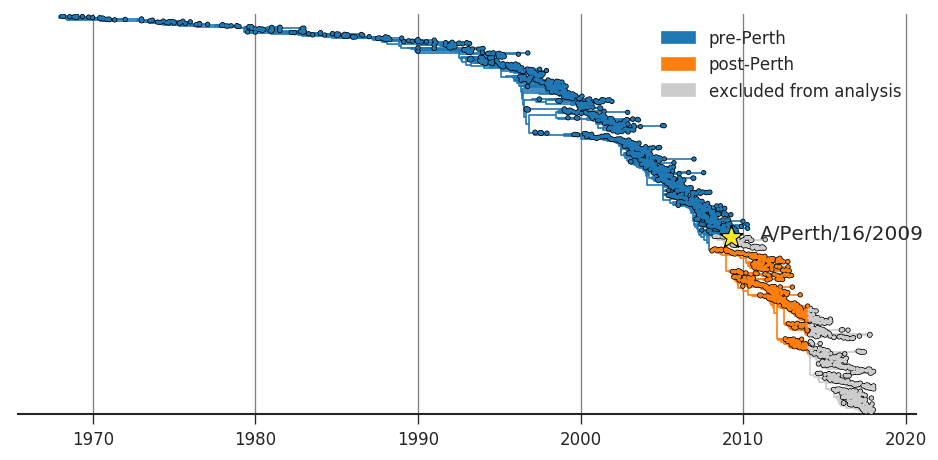

In [152]:
plot_tree(tree, dms_strain, color_per_label, excluded_clades=["perth"])
# plt.savefig("./results/plots/H3N2_phylogeny.pdf")

## Load unpassaged sequence tree and frequencies

To limit any potential bias of our experimentally-derived preferences towards sequences from cell- or egg-passaged isolates, we are additionally going to analyze all sequences from **unpassaged** isolates.
Due to the sparsity of directly sequenced isolates before 2009, we are going to limit this analysis of unpassaged isolates to be prospective (_i.e.,_ post-Perth/2009).

In [117]:
unpassaged_tree = load_and_annotate_tree_with_frequencies(
    "./data/flu_h3n2_ha_1968_2018_30v_unpassaged_tree.json.gz",
    "./data/flu_h3n2_ha_1968_2018_30v_unpassaged_frequencies.json.gz"
)

In [118]:
unpassaged_df = get_mutations_data_frame_for_tree(unpassaged_tree)

In [119]:
unpassaged_df.shape

(422, 13)

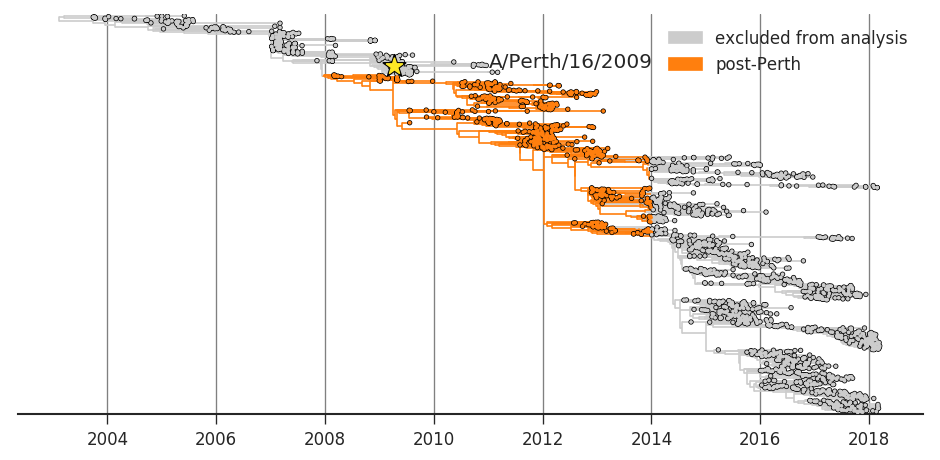

In [153]:
dms_strain_for_unpassaged_tree = find_dms_strain(unpassaged_tree)
unpassaged_color_per_label = color_per_label.copy()
unpassaged_color_per_label["pre-Perth"] = unpassaged_color_per_label["perth"]
plot_tree(unpassaged_tree, dms_strain_for_unpassaged_tree, unpassaged_color_per_label, excluded_clades=["perth", "pre-Perth"])
# plt.savefig("./results/plots/H3N2_unpassaged_tree.pdf")

## Maximum frequency by mutational effect for pre- and post-Perth nodes

To get a sense of how well mutational effect predicts success of nodes sampled after the Perth DMS strain, we look at the maximum frequency achieved by both pre- and post-Perth node by mutational effect across different site masks.

Nodes inside the Perth side branch clade are omitted from the analysis. Nodes occuring after 2014 are also omitted to avoid including recent low frequency variants that have not had time to resolve as fixed in the population.

In [120]:
df["date"].max()

2013.9856262833675

In [121]:
df["max_frequency_bins"].value_counts()

(0.0, 0.02]    769
(0.02, 0.1]    264
(0.99, 1.0]     77
(0.1, 0.5]      73
(0.5, 0.99]     15
Name: max_frequency_bins, dtype: int64

In [122]:
df["perth_status"].value_counts()

pre-Perth     1022
post-Perth     299
Name: perth_status, dtype: int64

### Distributions of maximum frequency by Perth/2009 mutational effect

In [123]:
def regplot_with_spearman_test(ax, group_df, permutations, precision, color_per_label,
                               fontsize, large_fontsize, group, title, effect_key="mut_effect"):
    rho, permutation_pvalue = spearman_permutation_test(
        group_df["max_frequency"],
        group_df[effect_key],
        permutations=permutations
    )
    print("%s: %s" % (group, permutation_pvalue))
    
    if permutation_pvalue < 1.0 / permutations:
        permutation_pvalue = 1.0 / permutations
        sign = "<"
    else:
        sign = "="
    
    label = "$\\rho = %.2f$\n$P %s %s$" % (rho, sign, round(permutation_pvalue, precision))
    sns.regplot(effect_key, "max_frequency", group_df, ax=ax, scatter_kws={"alpha": 0.3},
                color=color_per_label[group], line_kws={"color": "black", "lw": 1.5})

    ax.text(-19, 0.75, label, fontsize=fontsize)
    ax.set_xlabel("")
    
    if i == 0:
        ax.set_ylabel("max frequency", fontdict={"fontsize": large_fontsize})
    else:
        ax.set_ylabel("")
        
    ax.set_title(title, fontsize=large_fontsize)
    ax.tick_params(labelsize=fontsize)
    ax.get_yaxis().set_label_coords(-0.2, 0.5)
    ax.set_xlim(-20, 10)
    ax.set_ylim(-0.05, 1.05)

In [124]:
def histogram_for_group(ax, group_df, key, bins, color_per_label, frequency_bin,
                        fontsize, large_fontsize, frequency_bins, perth_clade, label_x_axis):
    n, hist_bins, patches = ax.hist(group_df[key].values, bins=bins, color=color_per_label[perth_clade])
    ax.axvline(group_df[key].mean(), c="black", lw=1.5)

    ax.set_title("max freq = %s" % frequency_bin, {"fontsize": fontsize}, loc="right")
    ax.set_xlabel("mutational effect", fontdict={"fontsize": large_fontsize})
    ax.tick_params(labelsize=fontsize)

    if i == np.median(np.arange(0, len(frequency_bins) - 1)) and j == 0:
        ax.set_ylabel("count", fontdict={"fontsize": large_fontsize})
        ax.get_yaxis().set_label_coords(-0.2, 0.5)
    else:
        ax.set_ylabel("")

    ax.set_xlim(-20, 10)

    y_upper_limit = n.max()

    if not label_x_axis:
        ax.get_xaxis().set_ticklabels([])
        ax.set_xlabel("")
        
    return y_upper_limit

pre-Perth: 0.0
post-Perth: 0.0055
post-Perth: 0.0


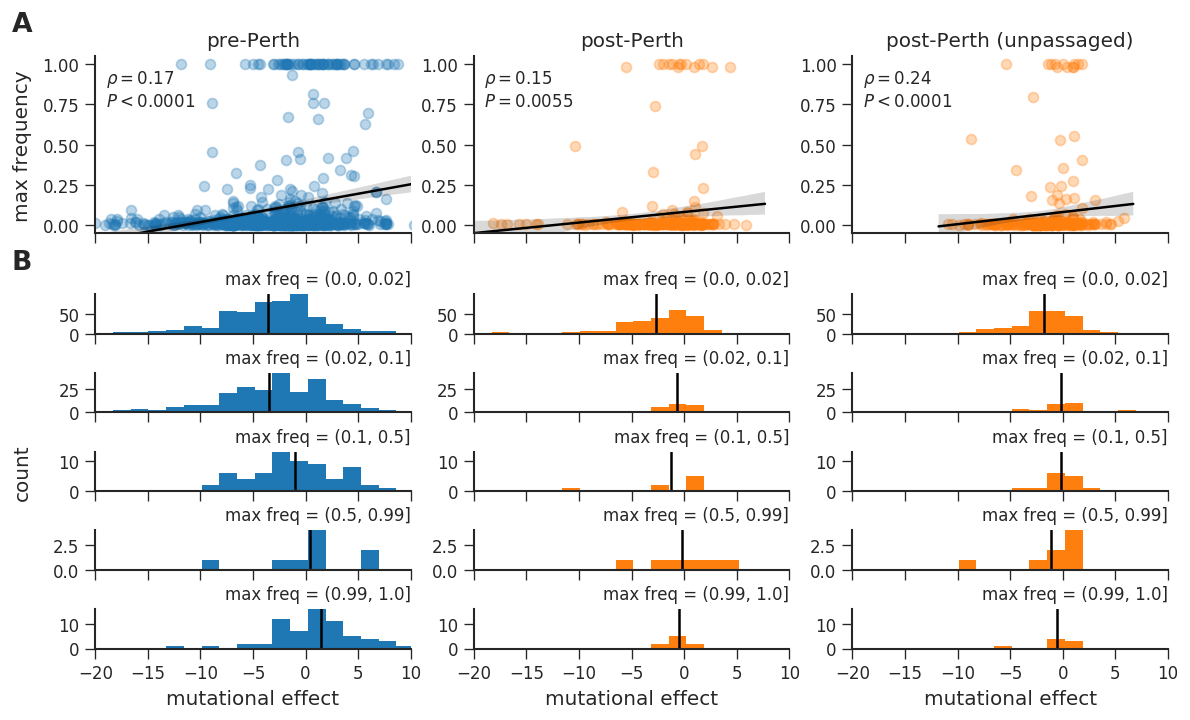

In [154]:
#
# Perth preferences.
#

fig = plt.figure(figsize=(10, 6))
gs0 = gridspec.GridSpec(2, 1, height_ratios=[1, 2], hspace=1.0)

gs00 = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs0[0])
gs01 = gridspec.GridSpecFromSubplotSpec(len(frequency_bins) - 1, 3, subplot_spec=gs0[1], hspace=1.0)

permutations = 10000
large_fontsize = 12
fontsize = 10
bins = np.linspace(-20, 12, 20)

#
# Scatterplot
#

grouped_df = df.groupby("perth_status")

for i, group in enumerate(("pre-Perth", "post-Perth")):
    ax = plt.subplot(gs00[0, i], )
    group_df = grouped_df.get_group(group)
    regplot_with_spearman_test(
        ax, group_df, permutations, precision,
        color_per_label, fontsize, large_fontsize,
        group, group
    )
    ax.get_xaxis().set_ticklabels([])

unpassaged_grouped_df = unpassaged_df.groupby("perth_status")
ax = plt.subplot(gs00[0, i + 1], )
group = "post-Perth"
group_df = unpassaged_grouped_df.get_group(group)
regplot_with_spearman_test(
    ax, group_df, permutations, precision,
    color_per_label, fontsize, large_fontsize,
    group, "post-Perth (unpassaged)"
)
ax.get_xaxis().set_ticklabels([])

#
# Histograms
#

key = "mut_effect"
data = df
grouped_data = data.groupby("max_frequency_bins")
num_groups = len(grouped_data.groups.keys())

axes_by_row = {}
max_by_row = {}
for i, (frequency_bin, frequency_bin_df) in enumerate(grouped_data):
    for j, perth_clade in enumerate(("pre-Perth", "post-Perth")):
        ax = plt.subplot(gs01[i, j])
        perth_clade_df = frequency_bin_df[frequency_bin_df["perth_status"] == perth_clade]
        if i != len(grouped_data) - 1:
            label_x_axis = False
        else:
            label_x_axis = True
            
        max_value = histogram_for_group(ax, perth_clade_df, key, bins, color_per_label,
                                        frequency_bin, fontsize, large_fontsize,
                                        frequency_bins, perth_clade, label_x_axis)
        
        if not i in max_by_row or max_by_row[i] < max_value:
            max_by_row[i] = max_value
        
        if not i in axes_by_row:
            axes_by_row[i] = []
        
        axes_by_row[i].append(ax)

unpassaged_grouped_data = unpassaged_df.groupby("max_frequency_bins")
perth_clade = "post-Perth"
for i, (frequency_bin, frequency_bin_df) in enumerate(unpassaged_grouped_data):
    ax = plt.subplot(gs01[i, 2])
    perth_clade_df = frequency_bin_df[frequency_bin_df["perth_status"] == perth_clade]
    if i != len(grouped_data) - 1:
        label_x_axis = False
    else:
        label_x_axis = True

    max_value = histogram_for_group(ax, perth_clade_df, key, bins, color_per_label,
                                    frequency_bin, fontsize, large_fontsize,
                                    frequency_bins, perth_clade, label_x_axis)

    if not i in max_by_row or max_by_row[i] < max_value:
        max_by_row[i] = max_value

    if not i in axes_by_row:
        axes_by_row[i] = []

    axes_by_row[i].append(ax)
        
# Set ylim for each row.
for row in axes_by_row:
    for ax in axes_by_row[row]:
        ax.set_ylim(0, np.ceil(max_by_row[row]))

# Annotate panel label.
fig.text(0.01, 0.98, "A", fontsize=16, weight="bold", horizontalalignment='left', verticalalignment='center')
fig.text(0.01, 0.65, "B", fontsize=16, weight="bold", horizontalalignment='left', verticalalignment='center')

gs0.tight_layout(fig, w_pad=1.0)
# plt.savefig("./results/plots/max-frequency-by-mutational-effect-for-Perth-preferences.pdf")

### Distributions of maximum frequency by WSN mutational effect

pre-Perth: 0.3
post-Perth: 0.222
post-Perth: 0.037


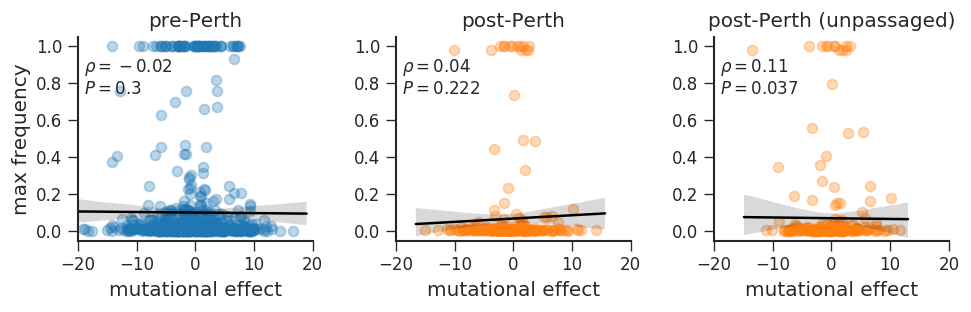

In [155]:
#
# WSN preferences
#

permutations = 1000

#
# Scatterplot
#

fig = plt.figure(figsize=(8, 2.5))
gs00 = gridspec.GridSpec(1, 3, bottom=0.3)

grouped_df = df.groupby("perth_status")

for i, group in enumerate(("pre-Perth", "post-Perth")):
    ax = plt.subplot(gs00[0, i], )
    group_df = grouped_df.get_group(group)
    regplot_with_spearman_test(
        ax, group_df, permutations, precision,
        color_per_label, fontsize, large_fontsize,
        group, group, "wsn_mut_effect"
    )
    ax.set_xlabel("mutational effect", fontdict={"fontsize": large_fontsize})
    ax.set_xlim(-20, 20)

unpassaged_grouped_df = unpassaged_df.groupby("perth_status")
ax = plt.subplot(gs00[0, i + 1], )
group = "post-Perth"
group_df = unpassaged_grouped_df.get_group(group)
regplot_with_spearman_test(
    ax, group_df, permutations, precision,
    color_per_label, fontsize, large_fontsize,
    group, "post-Perth (unpassaged)", "wsn_mut_effect"
)
ax.set_xlabel("mutational effect", fontdict={"fontsize": large_fontsize})
ax.set_xlim(-20, 20)

gs00.tight_layout(fig, pad=0.3, h_pad=0.0, w_pad=1.0)
# fig.savefig("./results/plots/max-frequency-by-mutational-effect-for-WSN-preferences-scatterplot.pdf")

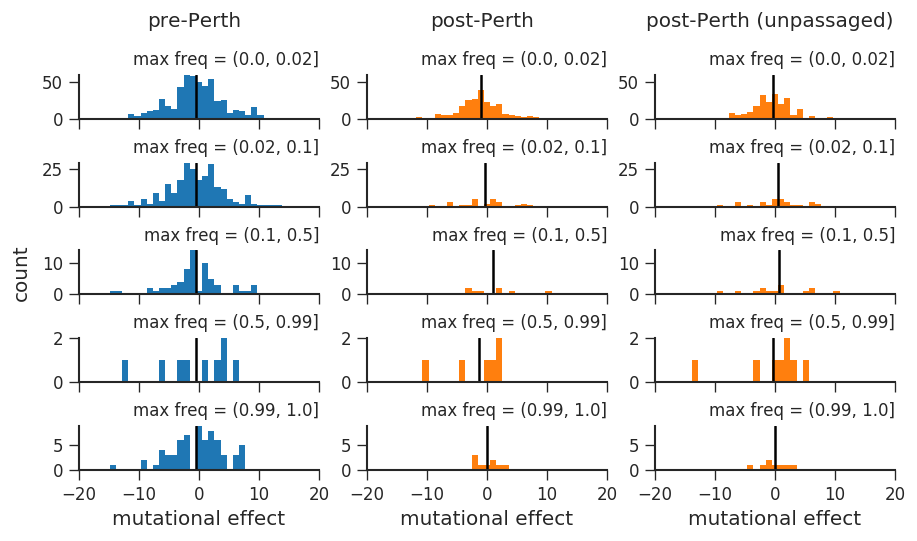

In [156]:
#
# Histograms
#

fig = plt.figure(figsize=(8, 4.5))
gs01 = gridspec.GridSpec(len(frequency_bins) - 1, 3, hspace=1.0)

key = "wsn_mut_effect"
data = df
grouped_data = data.groupby("max_frequency_bins")
num_groups = len(grouped_data.groups.keys())
bins = np.linspace(-20, 20, 40)

######
# New

axes_by_row = {}
max_by_row = {}
for i, (frequency_bin, frequency_bin_df) in enumerate(grouped_data):
    for j, perth_clade in enumerate(("pre-Perth", "post-Perth")):
        ax = plt.subplot(gs01[i, j])
        perth_clade_df = frequency_bin_df[frequency_bin_df["perth_status"] == perth_clade]
        if i != len(grouped_data) - 1:
            label_x_axis = False
        else:
            label_x_axis = True
            
        max_value = histogram_for_group(ax, perth_clade_df, key, bins, color_per_label,
                                        frequency_bin, fontsize, large_fontsize,
                                        frequency_bins, perth_clade, label_x_axis)
        
        if not i in max_by_row or max_by_row[i] < max_value:
            max_by_row[i] = max_value
        
        if not i in axes_by_row:
            axes_by_row[i] = []
        
        ax.set_xlim(-20, 20)
        axes_by_row[i].append(ax)

unpassaged_grouped_data = unpassaged_df.groupby("max_frequency_bins")
perth_clade = "post-Perth"
for i, (frequency_bin, frequency_bin_df) in enumerate(unpassaged_grouped_data):
    ax = plt.subplot(gs01[i, 2])
    perth_clade_df = frequency_bin_df[frequency_bin_df["perth_status"] == perth_clade]
    if i != len(grouped_data) - 1:
        label_x_axis = False
    else:
        label_x_axis = True

    max_value = histogram_for_group(ax, perth_clade_df, key, bins, color_per_label,
                                    frequency_bin, fontsize, large_fontsize,
                                    frequency_bins, perth_clade, label_x_axis)

    if not i in max_by_row or max_by_row[i] < max_value:
        max_by_row[i] = max_value

    if not i in axes_by_row:
        axes_by_row[i] = []

    ax.set_xlim(-20, 20)
    axes_by_row[i].append(ax)
        
# Set ylim for each row.
for row in axes_by_row:
    for ax in axes_by_row[row]:
        ax.set_ylim(0, np.ceil(max_by_row[row]))

fig.text(0.22, 0.98, "pre-Perth", fontsize=12, horizontalalignment='center', verticalalignment='center')
fig.text(0.52, 0.98, "post-Perth", fontsize=12, horizontalalignment='center', verticalalignment='center')
fig.text(0.82, 0.98, "post-Perth (unpassaged)", fontsize=12, horizontalalignment='center', verticalalignment='center')

fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)
# plt.savefig("./results/plots/max-frequency-by-mutational-effect-for-WSN-preferences-histograms.pdf")

## Inspect tip frequencies to determine lowest max frequency bin range

Text(0.5,1,'post-Perth')

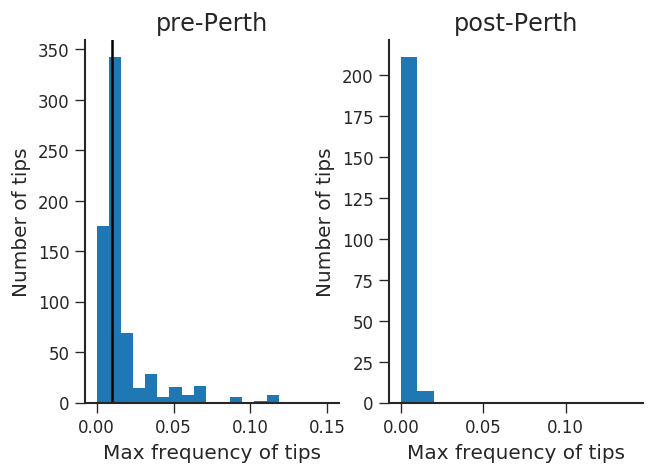

In [133]:
fig, axes = plt.subplots(1, 2, figsize=(6, 4))

ax = axes[0]
data = df[(df["tips"] == 0) & (df["perth_status"] == "pre-Perth")]
ax.hist(data["max_frequency"], bins=np.linspace(0, 0.15, 20))
ax.axvline(0.01, color="black")
ax.set_xlabel("Max frequency of tips")
ax.set_ylabel("Number of tips")
ax.set_title("pre-Perth")

ax = axes[1]
data = df[(df["tips"] == 0) & (df["perth_status"] == "post-Perth")]
ax.hist(data["max_frequency"], bins=np.arange(0, 0.15, 0.01))
ax.set_xlabel("Max frequency of tips")
ax.set_ylabel("Number of tips")
ax.set_title("post-Perth")

## Demonstrate maximum clade frequency calculation

In [134]:
# Find trunk node sampled after the given date.
min_date = 2000.0
max_date = 2014.0

for node in tree.find_clades():
    if node.is_trunk and node.attr["num_date"] > min_date:
        tree_to_plot = node
        break

In [135]:
lab_colors = [
    "#fceabb",
    "#a2acae",
    "#36729e"
]
trait_name = 'mut_effect'
traits = [node.attr[trait_name] for node in tree_to_plot.find_clades() if node.attr[trait_name] != 0]

In [136]:
color_bins = [-np.inf, -10, 0, np.inf]
pd.cut(traits, bins=color_bins).value_counts()

(-inf, -10.0]     49
(-10.0, 0.0]     755
(0.0, inf]       297
dtype: int64

In [137]:
counts = pd.cut(traits, bins=color_bins).value_counts()
counts / counts.sum()

(-inf, -10.0]    0.044505
(-10.0, 0.0]     0.685740
(0.0, inf]       0.269755
dtype: float64

In [138]:
counts.sum()

1101

In [139]:
# Define bins for mutational effects.
traits_by_clade = [{"clade": node.clade, trait_name: node.attr[trait_name]}
                   for node in tree_to_plot.find_clades() if node.attr[trait_name] != 0]
traits_df = pd.DataFrame(traits_by_clade)

In [140]:
traits_df["bin"] = pd.cut(traits_df[trait_name], bins=color_bins)

In [141]:
# Map bin to color.
bin_to_color = dict(zip(traits_df["bin"].unique(), lab_colors))
traits_df["color"] = traits_df.apply(lambda row: bin_to_color[row["bin"]], axis=1)

In [142]:
traits_df.head()

,clade,mut_effect,bin,color
0,1190,-11.873919,"(-inf, -10.0]",#fceabb
1,1194,-2.374629,"(-10.0, 0.0]",#a2acae
2,1197,-0.897093,"(-10.0, 0.0]",#a2acae
3,1200,-8.290591,"(-10.0, 0.0]",#a2acae
4,1201,-0.992814,"(-10.0, 0.0]",#a2acae


In [143]:
# Map color to node.
color_by_clade = dict(traits_df.loc[:, ["clade", "color"]].values)

In [145]:
# Load frequencies JSON file used by auspice. These data are compressed.
# Decompress JSON data and load into a Python dict.
with gzip.GzipFile("./data/flu_h3n2_ha_1968_2018_6v_frequencies.json.gz", "r") as json_uncompressed_fh:
    frequencies = json.loads(json_uncompressed_fh.read().decode('utf-8'))

pivots = np.array(frequencies["pivots"])
global_frequencies = {
    int(key.split(":")[-1]): np.array(values) for key, values in frequencies.items()
    if key.startswith("global_clade:")
}

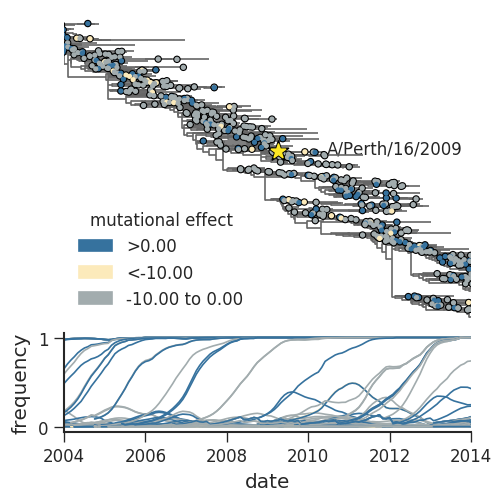

In [146]:
#
# Setup grid.
#

min_display_date = 2004
max_display_date = max_date
min_effect = 0.0

fig = plt.figure(figsize=(4, 4))
gs = gridspec.GridSpec(2, 1, hspace=0.0, height_ratios=[3.14, 1])

#
# Tree
#

ax = plt.subplot(gs[0])

yvalues = [node.yvalue for node in tree_to_plot.find_clades()]
y_span = max(yvalues)

trait_name = 'mut_effect'
traits = [node.attr[trait_name] for node in tree_to_plot.find_clades()]

#
# Setup the figure grid.
#

L=len([k for k in tree_to_plot.find_clades() if k.is_terminal()])

# Setup arrays for tip and internal node coordinates.
tip_circles_x = []
tip_circles_y = []
tip_circles_color = []
tip_circle_sizes = []

node_circles_x = []
node_circles_y = []
node_circles_color = []
node_line_widths = []
node_line_segments = []
node_line_colors = []

branch_line_segments = []
branch_line_widths = []
branch_line_colors = []
branch_line_labels = []
branch_color = "#666666"

mutation_circles_x = []
mutation_circles_y = []
mutation_circles_color = []
mutation_circle_sizes = []

for k in tree_to_plot.find_clades(): ## iterate over objects in tree
    x=k.attr["num_date"] ## or from x position determined earlier
    y=k.yvalue ## get y position from .drawTree that was run earlier, but could be anything else
    
    if k.parent is None:
        xp = None
    else:
        xp=k.parent.attr["num_date"] ## get x position of current object's parent

    if x==None: ## matplotlib won't plot Nones, like root
        x=0.0
    if xp==None:
        xp=x
    
    c = (0.4, 0.4, 0.4, 1.0)
    mut_c = "#ffffff"
    if trait_name in k.attr and np.abs(k.attr[trait_name]) > min_effect:
        mut_c = color_by_clade[k.clade]
            
    branchWidth=1
    if k.is_terminal(): ## if leaf...
        s=6 ## tip size can be fixed
        mut_s = 10
        tip_circle_sizes.append(s)
        tip_circles_x.append(x)
        tip_circles_y.append(y)
        tip_circles_color.append(c)
        
        if k.attr["perth_status"] != "perth" and xp is not None and np.abs(k.attr[trait_name]) > min_effect:
            mutation_circle_sizes.append(mut_s)
            mutation_circles_x.append(xp + ((x - xp) / 2.0))
            mutation_circles_y.append(y)
            mutation_circles_color.append(mut_c)
    else: ## if node...
        k_leaves = [child
                    for child in k.find_clades()
                    if child.is_terminal()]
        
        # Instead of scaling branch widths by the number of tips
        # in each clade, scale by the predicted frequency.
        #branchWidth += 15.0 * predicted_freq_by_clade.get(k.clade, 0.0)

        if len(k.clades)==1:
            node_circles_x.append(x)
            node_circles_y.append(y)
            node_circles_color.append(c)

        ax.plot([x,x],[k.clades[-1].yvalue, k.clades[0].yvalue], lw=branchWidth, color=branch_color, ls='-', zorder=9, solid_capstyle='round')
    
    branch_line_segments.append([(xp, y), (x, y)])
    branch_line_widths.append(branchWidth)
    branch_line_colors.append(branch_color)

branch_lc = LineCollection(branch_line_segments, zorder=9)
branch_lc.set_color(branch_line_colors)
branch_lc.set_linewidth(branch_line_widths)
branch_lc.set_label(branch_line_labels)
branch_lc.set_linestyle("-")
ax.add_collection(branch_lc)
    
# Add circles for tips and internal nodes.
tip_circle_sizes = np.array(tip_circle_sizes)
#ax.scatter(tip_circles_x, tip_circles_y, s=tip_circle_sizes, facecolor=tip_circles_color, edgecolor='none',zorder=11) ## plot circle for every tip
#ax.scatter(tip_circles_x, tip_circles_y, s=tip_circle_sizes*2, facecolor='k', edgecolor='none', zorder=10) ## plot black circle underneath
ax.scatter(node_circles_x, node_circles_y, facecolor=node_circles_color, s=50, edgecolor='none', zorder=10, lw=2, marker='|') ## mark every node in the tree to highlight that it's a multitype tree

# Add circles for mutations.
mutation_circle_sizes = np.array(mutation_circle_sizes)
ax.scatter(mutation_circles_x, mutation_circles_y, s=mutation_circle_sizes, facecolor=mutation_circles_color, edgecolor='none',zorder=11) ## plot circle for every tip
ax.scatter(mutation_circles_x, mutation_circles_y, s=mutation_circle_sizes*2, facecolor='k', edgecolor='none', zorder=10) ## plot black circle underneath

# Call out the DMS strain with a bordered star.
star_size = 80
ax.scatter([dms_strain.attr["num_date"]], [dms_strain.yvalue], marker="*", s=star_size, facecolor=["#fde725"], zorder=20)
ax.scatter([dms_strain.attr["num_date"]], [dms_strain.yvalue], marker="*", s=star_size * 2, facecolor=["#000000"], zorder=19)

# Annotate the DMS strain name.
ax.text(dms_strain.attr["num_date"] + 1.2, dms_strain.yvalue - 8, dms_strain.strain, fontdict={"fontsize": 10})

ax.set_xlim(min_display_date, max_display_date)
ax.set_ylim(300, 1500)

ax.spines['top'].set_visible(False) ## no axes
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

#ax.grid(axis='x', ls='-', color='grey')
ax.tick_params(axis='y',size=0)
ax.tick_params(axis='x',size=0)
ax.set_xticklabels([])
ax.set_yticklabels([])

patches = []

for interval, color in bin_to_color.items():
    if interval.left == -np.inf:
        label = "<%.2f" % interval.right
    elif interval.right == np.inf:
        label= ">%.2f" % interval.left
    else:
        label = "%.2f to %.2f" % (interval.left, interval.right)
        
    patches.append(mpatches.Patch(color=color, label=label))

legend = ax.legend(handles=patches, loc="lower left", title="mutational effect", fontsize=10)
legend.get_title().set_fontsize(10)

#
# Frequencies
#

ax = plt.subplot(gs[1])
lw = 1
max_abs_trait = max(np.abs(traits))

for node in tree_to_plot.find_clades():
    if node.attr["perth_status"] != "perth" and np.abs(node.attr[trait_name]) > min_effect:
        node_frequencies = global_frequencies[node.clade]
        x = pivots[node_frequencies.argmax()]
        y = node_frequencies.max()
        nonzero = np.nonzero(node_frequencies)
        clade_color = color_by_clade[node.clade]
        ax.plot(pivots[nonzero], node_frequencies[nonzero], lw=lw, c=clade_color)

        ax.set_xlim(min_display_date, max_display_date)
        ax.set_xlabel("date")
        ax.set_ylabel("frequency")
        ax.label_outer()

gs.tight_layout(fig, pad=0.0)
# plt.savefig("./results/plots/phylogeny-and-frequency-of-mutational-effects.pdf")

Replot the tree and frequencies by head and stalk mutation status.

The head is denoted by two cysteines at sites 52 and 277 (H3 numbering) and the amino acids between those sites.

In [147]:
cmap = plt.get_cmap("tab10")

In [148]:
cmap(0)

(0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0)

In [149]:
#head_stalk_colors = [lab_colors[2], lab_colors[0]]
head_stalk_colors = [cmap(4), cmap(9)]

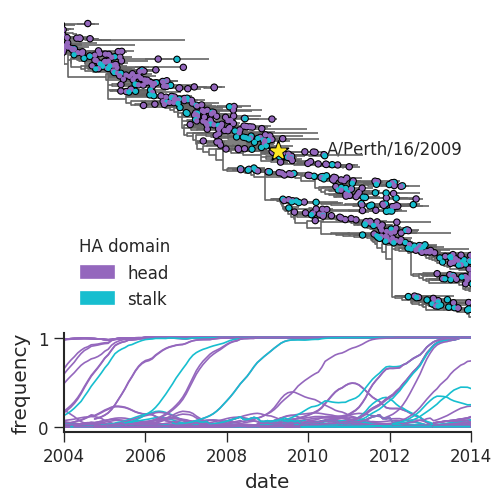

In [150]:
#
# Setup grid.
#

min_display_date = 2004
max_display_date = max_date
min_effect = 0.0

fig = plt.figure(figsize=(4, 4))
gs = gridspec.GridSpec(2, 1, hspace=0.0, height_ratios=[3.14, 1])

#
# Tree
#

ax = plt.subplot(gs[0])

yvalues = [node.yvalue for node in tree_to_plot.find_clades()]
y_span = max(yvalues)

trait_name = 'mut_effect'
traits = [node.attr[trait_name] for node in tree_to_plot.find_clades()]

#
# Setup the figure grid.
#

L=len([k for k in tree_to_plot.find_clades() if k.is_terminal()])

# Setup arrays for tip and internal node coordinates.
tip_circles_x = []
tip_circles_y = []
tip_circles_color = []
tip_circle_sizes = []

node_circles_x = []
node_circles_y = []
node_circles_color = []
node_line_widths = []
node_line_segments = []
node_line_colors = []

branch_line_segments = []
branch_line_widths = []
branch_line_colors = []
branch_line_labels = []
branch_color = "#666666"

mutation_circles_x = []
mutation_circles_y = []
mutation_circles_color = []
mutation_circle_sizes = []

for k in tree_to_plot.find_clades(): ## iterate over objects in tree
    x=k.attr["num_date"] ## or from x position determined earlier
    y=k.yvalue ## get y position from .drawTree that was run earlier, but could be anything else
    
    if k.parent is None:
        xp = None
    else:
        xp=k.parent.attr["num_date"] ## get x position of current object's parent

    if x==None: ## matplotlib won't plot Nones, like root
        x=0.0
    if xp==None:
        xp=x
    
    c = (0.4, 0.4, 0.4, 1.0)
    mut_c = "#ffffff"
    if trait_name in k.attr and np.abs(k.attr[trait_name]) > min_effect:
        if node_has_head_mutations(k):
            mut_c = head_stalk_colors[0]
        else:
            mut_c = head_stalk_colors[1]
            
    branchWidth=1
    if k.is_terminal(): ## if leaf...
        s=6 ## tip size can be fixed
        mut_s = 10
        tip_circle_sizes.append(s)
        tip_circles_x.append(x)
        tip_circles_y.append(y)
        tip_circles_color.append(c)
        
        if k.attr["perth_status"] != "perth" and xp is not None and np.abs(k.attr[trait_name]) > min_effect:
            mutation_circle_sizes.append(mut_s)
            mutation_circles_x.append(xp + ((x - xp) / 2.0))
            mutation_circles_y.append(y)
            mutation_circles_color.append(mut_c)
    else: ## if node...
        k_leaves = [child
                    for child in k.find_clades()
                    if child.is_terminal()]
        
        # Instead of scaling branch widths by the number of tips
        # in each clade, scale by the predicted frequency.
        #branchWidth += 15.0 * predicted_freq_by_clade.get(k.clade, 0.0)

        if len(k.clades)==1:
            node_circles_x.append(x)
            node_circles_y.append(y)
            node_circles_color.append(c)

        ax.plot([x,x],[k.clades[-1].yvalue, k.clades[0].yvalue], lw=branchWidth, color=branch_color, ls='-', zorder=9, solid_capstyle='round')
    
    branch_line_segments.append([(xp, y), (x, y)])
    branch_line_widths.append(branchWidth)
    branch_line_colors.append(branch_color)

branch_lc = LineCollection(branch_line_segments, zorder=9)
branch_lc.set_color(branch_line_colors)
branch_lc.set_linewidth(branch_line_widths)
branch_lc.set_label(branch_line_labels)
branch_lc.set_linestyle("-")
ax.add_collection(branch_lc)
    
# Add circles for tips and internal nodes.
tip_circle_sizes = np.array(tip_circle_sizes)
#ax.scatter(tip_circles_x, tip_circles_y, s=tip_circle_sizes, facecolor=tip_circles_color, edgecolor='none',zorder=11) ## plot circle for every tip
#ax.scatter(tip_circles_x, tip_circles_y, s=tip_circle_sizes*2, facecolor='k', edgecolor='none', zorder=10) ## plot black circle underneath
ax.scatter(node_circles_x, node_circles_y, facecolor=node_circles_color, s=50, edgecolor='none', zorder=10, lw=2, marker='|') ## mark every node in the tree to highlight that it's a multitype tree

# Add circles for mutations.
mutation_circle_sizes = np.array(mutation_circle_sizes)
ax.scatter(mutation_circles_x, mutation_circles_y, s=mutation_circle_sizes, facecolor=mutation_circles_color, edgecolor='none',zorder=11) ## plot circle for every tip
ax.scatter(mutation_circles_x, mutation_circles_y, s=mutation_circle_sizes*2, facecolor='k', edgecolor='none', zorder=10) ## plot black circle underneath

# Call out the DMS strain with a bordered star.
star_size = 80
ax.scatter([dms_strain.attr["num_date"]], [dms_strain.yvalue], marker="*", s=star_size, facecolor=["#fde725"], zorder=20)
ax.scatter([dms_strain.attr["num_date"]], [dms_strain.yvalue], marker="*", s=star_size * 2, facecolor=["#000000"], zorder=19)

# Annotate the DMS strain name.
ax.text(dms_strain.attr["num_date"] + 1.2, dms_strain.yvalue - 8, dms_strain.strain, fontdict={"fontsize": 10})

ax.set_xlim(min_display_date, max_display_date)
ax.set_ylim(300, 1500)

ax.spines['top'].set_visible(False) ## no axes
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

#ax.grid(axis='x', ls='-', color='grey')
ax.tick_params(axis='y',size=0)
ax.tick_params(axis='x',size=0)
ax.set_xticklabels([])
ax.set_yticklabels([])

patches = []

for domain, color in zip(["head", "stalk"], head_stalk_colors):
    patches.append(mpatches.Patch(color=color, label=domain))

legend = ax.legend(handles=patches, loc="lower left", title="HA domain", fontsize=10)
legend.get_title().set_fontsize(10)

#
# Frequencies
#

ax = plt.subplot(gs[1])
lw = 1
max_abs_trait = max(np.abs(traits))

for node in tree_to_plot.find_clades():
    if node.attr["perth_status"] != "perth" and np.abs(node.attr[trait_name]) > min_effect:
        node_frequencies = global_frequencies[node.clade]
        x = pivots[node_frequencies.argmax()]
        y = node_frequencies.max()
        nonzero = np.nonzero(node_frequencies)
        
        if node_has_head_mutations(node):
            #clade_color = lab_colors[2]
            clade_color = head_stalk_colors[0]
        else:
            clade_color = head_stalk_colors[1]
            #clade_color = lab_colors[0]
            
        ax.plot(pivots[nonzero], node_frequencies[nonzero], lw=lw, c=clade_color)

        ax.set_xlim(min_display_date, max_display_date)
        ax.set_xlabel("date")
        ax.set_ylabel("frequency")
        ax.label_outer()

gs.tight_layout(fig, pad=0.0)
# plt.savefig("./results/plots/phylogeny-and-frequency-of-head-stalk-mutations.pdf")

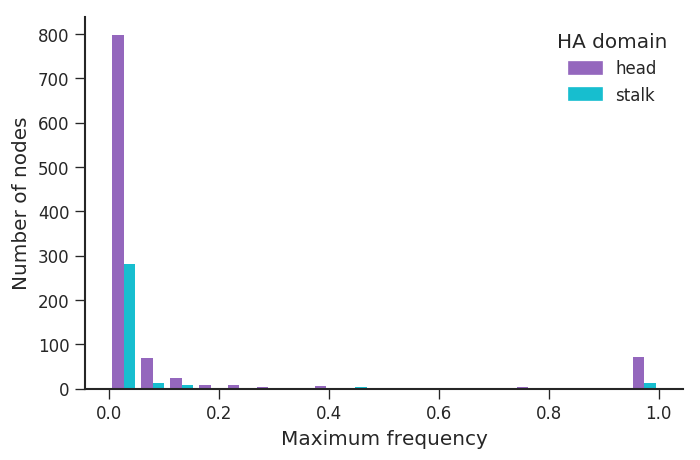

In [151]:
bins = np.linspace(0, 1, 20)
#data = df[df["terminal"] == False]
data = df
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

hist_data = np.array([
    data[data["has_head_mutations"] == True]["max_frequency"].values,
    data[data["has_head_mutations"] == False]["max_frequency"].values
])
n, hist_bins, patches = ax.hist(hist_data, bins=bins, histtype="bar", color=head_stalk_colors)

ax.set_xlabel("Maximum frequency")
ax.set_ylabel("Number of nodes")

patches = []
for domain, color in zip(["head", "stalk"], head_stalk_colors):
    patches.append(mpatches.Patch(color=color, label=domain))

legend = ax.legend(handles=patches, title="HA domain", fontsize=10)

fig.tight_layout()
# plt.savefig("./results/plots/frequency-histograms-for-head-stalk-mutations.pdf")